In [ ]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [2]:
def make_batch(sentences):
    input_batch = [[src_vocab[i] for i in sentences[0].split()]]
    output_batch = [[tgt_vocab[i] for i in sentences[1].split()]]
    target_batch = [[tgt_vocab[i] for i in sentences[2].split()]]
    return torch.LongTensor(input_batch), torch.LongTensor(output_batch), torch.LongTensor(target_batch)

In [3]:
#位置编码计算

class PositionalEncoding(nn.Module):
    def __init__(self, max_len=5000, dropout=0.1):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        def cal_angel(position, hid_idx):
            return position / np.power(10000, 2 * (hid_idx // 2) / d_model)
        def get_pos_angel(position):
            return [cal_angel(position, hid_idx) for hid_idx in range(d_model)]
        
        pe = np.array([get_pos_angel(pos_i) for pos_i in range(max_len)])
        pe[:, 0::2] = np.sin(pe[:, 0::2])
        pe[:, 1::2] = np.cos(pe[:, 1::2])
        pe = torch.FloatTensor(pe)
        #pe:[max_len * d_model]
        pe = pe.unsqueeze(1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        #x: [seq_len, batch_size, d_model]
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [4]:
#对<pad>掩码进行标识

def get_attn_pad_mask(seq_q, seq_k):
    batch_size, len_q = seq_q.size()
    batch_size, len_k = seq_k.size()

    pad_attn_mask = seq_k.data.eq(0).unsqueeze(1) #[batch_size, 1, len_k]对pad做标识为true,排除对注意力计算的影响
    return pad_attn_mask.expand(batch_size, len_q, len_k)

In [5]:
def get_attn_subsequent_mask(seq):
    #seq: [batch_size, tgt_len]
    attn_shape = [seq.size(0), seq.size(1), seq.size(1)]
    #attn_shape: [batch_size, tgt_len, tgt_len]
    subsequence_mask = np.triu(np.ones(attn_shape), k=1)
    """
        [[0, 1, 1, 1, 1],  
         [0, 0, 1, 1, 1],
         [0, 0, 0, 1, 1],
         [0, 0, 0, 0, 1],
         [0, 0, 0, 0, 0]]"""
    subsequence_mask = torch.from_numpy(subsequence_mask).bool()
    return subsequence_mask

In [6]:
#注意力分数计算
class  Scaled_Dot_Product_Attention(nn.Module):
    def __init__(self):
        super(Scaled_Dot_Product_Attention, self).__init__()
        
    def forward(self, Q, K, V, attn_mask):
        #Q: [batch_size, n_heads, len_q, d_k]
        #K: [batch_size, n_heads, len_q, d_k]
        #V: [batch_size, n_heads, len_q, d_v]
        scores = torch.matmul(Q, K.transpose(-1, -2)) / np.sqrt(d_k)
        scores = scores.masked_fill_(attn_mask, -1e9)
        attn = nn.Softmax(dim=-1)(scores)
        context = torch.matmul(attn, V) #attn: [batch_size, n_heads, len_q, d_v]
        return context, attn

In [7]:
#多头注意力

class Muti_Head_Attention(nn.Module):
    def __init__(self):
        super(Muti_Head_Attention, self).__init__()
        self.W_Q = nn.Linear(d_model, d_k * n_heads)
        self.W_K = nn.Linear(d_model, d_k * n_heads)
        self.W_V = nn.Linear(d_model, d_v * n_heads)
        self.linear = nn.Linear(d_v * n_heads, d_model)
        self.layer_norm = nn.LayerNorm(d_model)

    def forward(self, q, k, v, attn_mask):
        q_clone, batch_size = q, q.size(0)
        # 这个多头分为这几个步骤，首先映射分头，然后计算attn_scores，然后计算attn_value;
        # 输入进来的数据形状： q: [batch_size, len_q, d_model], k: [batch_size, len_k, d_model], v: [batch_size, len_k, d_model]
        Q = self.W_Q(q).view(batch_size, -1, n_heads, d_k).transpose(1, 2)
        K = self.W_K(k).view(batch_size, -1, n_heads, d_k).transpose(1, 2)
        V = self.W_V(v).view(batch_size, -1, n_heads, d_v).transpose(1, 2)
        # 输入进行的attn_mask形状是 batch_size x len_q x len_k
        attn_mask = attn_mask.unsqueeze(1).repeat(1, n_heads, 1, 1 )#[batch_size, n_heads, len_q, len_k]，就是把pad信息重复了n个头上
        # context: [batch_size, n_heads, len_q, d_v], attn: [batch_size, n_heads, len_q, len_k]
        context, attn = Scaled_Dot_Product_Attention().forward(Q, K, V, attn_mask)
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, n_heads * d_v)
        output = self.linear(context)

        return self.layer_norm(q_clone + output), attn

In [8]:
#构建FeedForward层

class PoswiseFeedForward(nn.Module):
    def __init__(self) :
        super(PoswiseFeedForward, self).__init__()
        self.conv1 = nn.Conv1d(d_model, d_ff, kernel_size=1)
        self.conv2 = nn.Conv1d(d_ff, d_model, kernel_size=1)
        self.layer_norm = nn.LayerNorm(d_model)
    
    def forward(self, inputs):
        inputs_clone = inputs # inputs : [batch_size, len_q, d_model]
        outputs = F.relu(self.conv1(inputs.transpose(1, 2)))
        outputs = self.conv2(outputs).transpose(1, 2)
        return self.layer_norm(outputs + inputs_clone)

In [9]:
# EncoderLayer ：包含两个部分，多头注意力机制和前馈神经网络

class EncoderLayer(nn.Module):
    def __init__(self):
        super(EncoderLayer, self).__init__()
        self.enc_attn = Muti_Head_Attention()
        self.enc_ffn = PoswiseFeedForward()

    def forward(self, enc_inputs, enc_self_attn_mask):
        enc_outputs, attn = self.enc_attn(enc_inputs, enc_inputs, enc_inputs, enc_self_attn_mask)
        enc_outputs = self.enc_ffn(enc_outputs)
        return enc_outputs, attn 

In [10]:
#Encoder 部分包含三个部分：词向量embedding，位置编码部分，注意力层及后续的前馈神经网络

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.src_emb = nn.Embedding(src_vocab_size, d_model)
        self.pos_emb = PositionalEncoding()
        self.layers = nn.ModuleList([EncoderLayer() for _ in range(n_layers)])
    def forward(self, enc_inputs):
        #enc_inputs: [batch_size, source_len]
        enc_outputs = self.src_emb(enc_inputs) #enc_inputs: [batch_size, source_len, d_model]
        enc_outputs = self.pos_emb(enc_outputs.transpose(0, 1)).transpose(0, 1)
        
        enc_self_attn_mask = get_attn_pad_mask(enc_inputs, enc_inputs)
        enc_self_attns = []
        for layer in self.layers:
            enc_outputs, attn = layer(enc_outputs, enc_self_attn_mask)
            enc_self_attns.append(attn)

        return enc_outputs, enc_self_attns

In [11]:
class DecoderLayer(nn.Module):
    def __init__(self):
        super(DecoderLayer, self).__init__()
        self.dec_self_attn = Muti_Head_Attention()
        self.dec_enc_attn = Muti_Head_Attention()
        self.dec_ffn = PoswiseFeedForward()

    def forward(self, dec_inputs, enc_outputs, dec_self_attn_mask, dec_enc_attn_mask):
        dec_outputs, dec_self_attn = self.dec_self_attn(dec_inputs, dec_inputs, dec_inputs, dec_self_attn_mask)
        dec_outputs, dec_enc_attn = self.dec_enc_attn(dec_outputs, enc_outputs, enc_outputs, dec_enc_attn_mask)
        dec_outputs = self.dec_ffn(dec_outputs)

        return dec_outputs, dec_self_attn, dec_enc_attn

In [12]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.tgt_emb = nn.Embedding(tgt_vocab_size, d_model)
        self.pos_emb = PositionalEncoding()
        self.layers = nn.ModuleList([DecoderLayer() for _ in range(n_layers)])

    def forward(self, dec_inputs, enc_inputs, enc_outputs):
        dec_outputs = self.tgt_emb(dec_inputs) # [batch_size, tgt_len, d_model]
        dec_outputs = self.pos_emb(dec_outputs.transpose(0, 1)).transpose(0, 1)

        ## get_attn_pad_mask 自注意力层的时候的pad 部分
        dec_self_attn_pad_mask = get_attn_pad_mask(dec_inputs, dec_inputs)
         ## get_attn_subsequent_mask 这个做的是自注意层的mask部分
        dec_self_attn_subsequent_mask = get_attn_subsequent_mask(dec_inputs)
        ## 两个矩阵相加，大于0的为1，不大于0的为0，为1的在之后就会被fill到无限小
        dec_self_attn_mask = torch.gt(dec_self_attn_pad_mask + dec_self_attn_subsequent_mask, other=0)
        ## 这个做的是交互注意力机制中的mask矩阵，enc的输入是k，去看这个k里面哪些是pad符号, 给后面的模型
        dec_enc_attn_mask = get_attn_pad_mask(dec_inputs, enc_inputs)
        dec_self_attns, dec_enc_attns = [], []
        for layer in self.layers:
            dec_outputs, dec_self_attn, dec_enc_attn = layer(dec_outputs, enc_outputs, dec_self_attn_mask, dec_enc_attn_mask)
            dec_self_attns.append(dec_self_attn)
            dec_enc_attns.append(dec_enc_attn)

        return dec_outputs, dec_self_attns, dec_enc_attns

In [13]:
class Transformer(nn.Module):
    def __init__(self):
        super(Transformer, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.projection = nn.Linear(d_model, tgt_vocab_size)

    def forward(self, enc_inputs, dec_inputs):
        #enc_inputs: [batch_size, src_len], dec_inputs: [batch_size, tgt_len]
        enc_outputs, enc_self_attns = self.encoder(enc_inputs)
        dec_outputs, dec_self_attns, dec_enc_attns = self.decoder(dec_inputs, enc_inputs, enc_outputs)
        ## dec_outputs做映射到词表大小
        dec_logits = self.projection(dec_outputs) # [batch_size, src_vocab_size, tgt_vocab_size]
        
        return dec_logits.view(-1, dec_logits.size(-1)), enc_self_attns, dec_self_attns, dec_enc_attns

In [14]:
def greedy_decoder(model, enc_input, start_symble):
    enc_output, enc_self_attn = model.encoder(enc_input)
    dec_input = torch.zeros(1, 5).type_as(enc_input.data)
    next_symble = start_symble
    for i in range(0, 5):
        dec_input[0][i] = next_symble
        dec_output, _, _ = model.decoder(dec_input, enc_input, enc_output)
        projected = model.projection(dec_output)
        prob = projected.squeeze(0).max(dim=-1, keepdim=False)[1]
        next_word = prob.data[i]
        next_symble = next_word.item()
    
    return dec_input

In [15]:
def showgraph(attn, losses):
    if losses is not None:
        # 绘制训练损失折线图
        plt.figure(figsize=(8, 6))
        plt.plot(losses, label="Training Loss")
        plt.title("Training Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid(True)
        plt.show()
    elif attn is not None:
        attn = attn[-1].squeeze(0)[0]
        attn = attn.squeeze(0).data.numpy()
        fig = plt.figure(figsize=(n_heads, n_heads))
        ax = fig.add_subplot(1, 1, 1)
        ax.matshow(attn, cmap='viridis')

        x_labels = [''] + sentences[0].split()
        y_labels = [''] + sentences[2].split()

        ax.set_xticks(range(len(x_labels)))
        ax.set_xticklabels(x_labels, fontdict={'fontsize' : 14}, rotation=90)
        ax.set_yticks(range(len(y_labels)))
        ax.set_yticklabels(y_labels, fontdict={'fontsize' : 14})

        plt.show()

Epoch:0001, loss = 1.924310
Epoch:0002, loss = 0.852155
Epoch:0003, loss = 0.771032
Epoch:0004, loss = 0.335491
Epoch:0005, loss = 0.064271
Epoch:0006, loss = 0.047940
Epoch:0007, loss = 0.033354
Epoch:0008, loss = 0.020718
Epoch:0009, loss = 0.007646
Epoch:0010, loss = 0.002793
Epoch:0011, loss = 0.001406
Epoch:0012, loss = 0.001167
Epoch:0013, loss = 0.000891
Epoch:0014, loss = 0.000987
Epoch:0015, loss = 0.001210
Epoch:0016, loss = 0.001375
Epoch:0017, loss = 0.001720
Epoch:0018, loss = 0.001161
Epoch:0019, loss = 0.001964
Epoch:0020, loss = 0.001560
Epoch:0021, loss = 0.001207
Epoch:0022, loss = 0.000946
Epoch:0023, loss = 0.000979
Epoch:0024, loss = 0.000824
Epoch:0025, loss = 0.000643
Epoch:0026, loss = 0.000605
Epoch:0027, loss = 0.000470
Epoch:0028, loss = 0.000372
Epoch:0029, loss = 0.000356
Epoch:0030, loss = 0.000439
Epoch:0031, loss = 0.000340
Epoch:0032, loss = 0.000270
Epoch:0033, loss = 0.000263
Epoch:0034, loss = 0.000223
Epoch:0035, loss = 0.000179
Epoch:0036, loss = 0

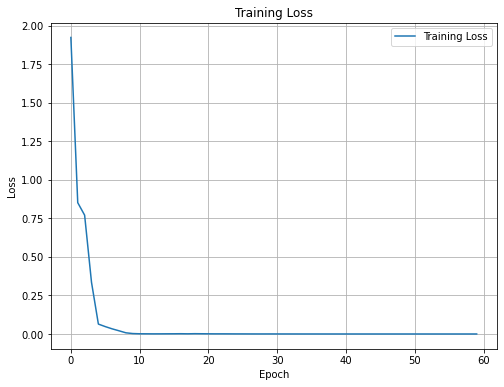

first head of last state enc_self_attns


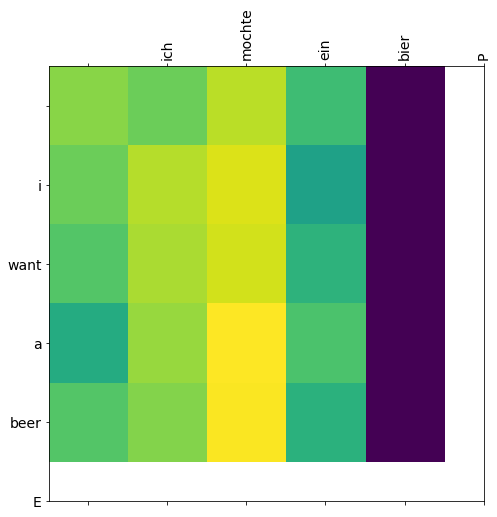

first head of last state dec_self_attns


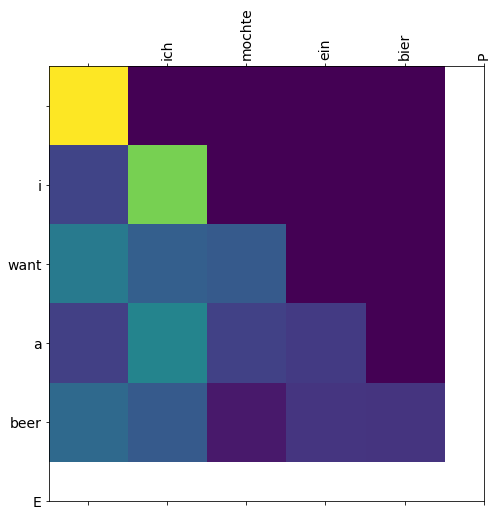

first head of last state dec_enc_attns


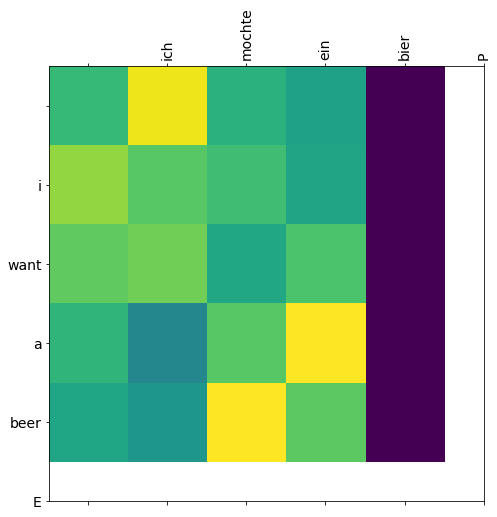

In [16]:
if __name__ == '__main__':
    #句子的输入部分，分别是: 编码端输入，解码端输入，解码端真实标签
    #S表示开始标志，E表示结束标志，P表示填充字符
    sentences = ['ich mochte ein bier P', 'S i want a beer', 'i want a beer E']

    # Transformer Parameters
    # Padding Should be Zero
    ## 构建词表
    src_vocab = {'P': 0, 'ich': 1, 'mochte': 2, 'ein': 3, 'bier': 4}
    src_vocab_size = len(src_vocab)

    tgt_vocab = {'P': 0, 'i': 1, 'want': 2, 'a': 3, 'beer': 4, 'S': 5, 'E': 6}
    number_dict = {i: w for i, w in enumerate(tgt_vocab)}
    tgt_vocab_size = len(tgt_vocab)

    src_len = 5  # length of source
    tgt_len = 5  # length of target

    ## 模型参数
    d_model = 512  # Embedding Size
    d_ff = 2048  # FeedForward dimension
    d_k = d_v = 64  # dimension of K(=Q), V
    n_layers = 6  # number of Encoder and Decoder Layer
    n_heads = 8  # number of heads in Multi-Head Attention

    model = Transformer()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    enc_input, dec_input, tgt_batch = make_batch(sentences)

    losses = []
    for epoch in range(60):
        optimizer.zero_grad()
        output, enc_self_attns, dec_self_attns, dec_enc_attns = model(enc_input, dec_input)
        loss = criterion(output, tgt_batch.contiguous().view(-1))
        losses.append(loss.item())
        print(f"Epoch:{(epoch + 1):04d}, loss = {loss:.6f}")
        loss.backward()
        optimizer.step()


#Test
greedy_dec_input = greedy_decoder(model, enc_input, tgt_vocab['S'])
predict, _, _, _ = model(enc_input, greedy_dec_input)
predict = predict.data.max(dim=-1, keepdim=True)[1]
print(sentences[0], '->', [number_dict[n.item()] for n in predict.squeeze()])

print("Training Loss")
showgraph(attn=None, losses=losses)

print("first head of last state enc_self_attns")
showgraph(attn=enc_self_attns, losses=None)

print("first head of last state dec_self_attns")
showgraph(attn=dec_self_attns, losses=None)

print("first head of last state dec_enc_attns")
showgraph(attn=dec_enc_attns, losses=None)